In [2]:
import xarray as xr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import functions.eddy_feedback as ef

# Import various EFP data

In [3]:
daily_path = '/home/links/ct715/eddy_feedback/chapter1/efp_random/data/daily_efp_8models.csv'

day = pd.read_csv(daily_path, index_col=0)

In [4]:
mixed_path = '/home/links/ct715/eddy_feedback/chapter1/efp_random/data/non-regridded_efp_AWI-fabricated.csv'

mix = pd.read_csv(mixed_path, index_col=0)

### Match subset of models

In [5]:
mix_subset = mix[mix['model'].isin(day['model'].unique())].sort_values(by='model').reset_index(drop=True)
mix_subset

,model,efp_nh,efp_sh
0,AWI-CM-1-1-MR,0.3724,0.4354
1,CNRM-CM6-1,0.2421,0.2082
2,CanESM5,0.4256,0.4618
3,FGOALS-f3-L,0.2354,0.1274
4,HadGEM3-GC31-LL,0.2730,0.2951
5,HadGEM3-GC31-MM,0.3137,0.3002
6,IPSL-CM6A-LR,0.2719,0.1959
7,MIROC6,0.2213,0.3253


In [6]:
# Example: assume your dfs are called day, mix, mix_subset
# Add a column to identify which dataframe they came from
day['dataset'] = 'Daily-mean'
mix['dataset'] = 'Mixed-freq.'
mix_subset['dataset'] = 'Mixed-freq. (8 models)'

# Concatenate them
df_all = pd.concat([day, mix, mix_subset], ignore_index=True)

# Melt to long format for seaborn
df_melt = df_all.melt(id_vars=['model', 'dataset'], 
                      value_vars=['efp_nh', 'efp_sh'],
                      var_name='hemisphere',
                      value_name='efp')


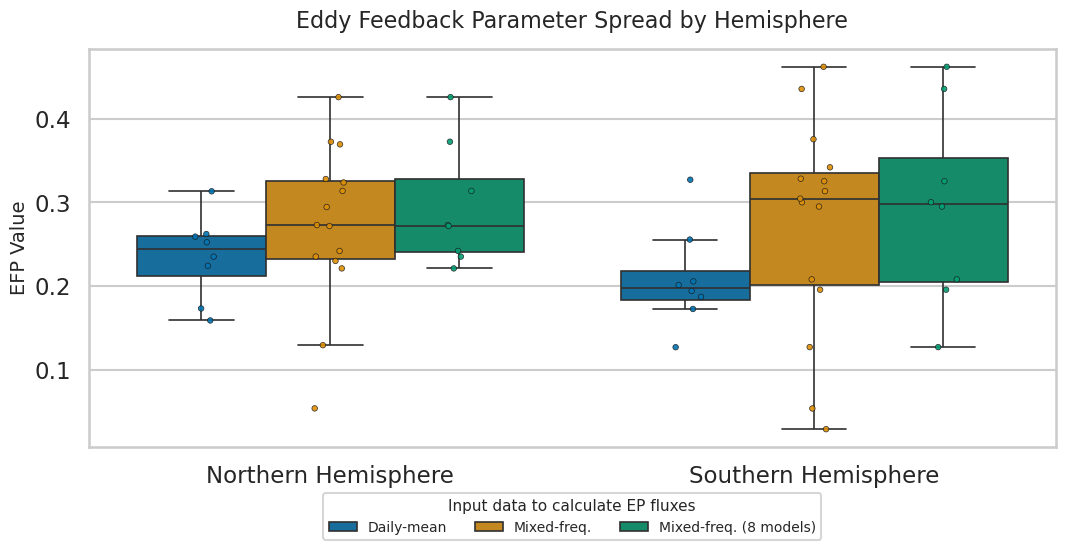

In [7]:
# Set style and context for clarity
sns.set_theme(style="whitegrid", context="talk", palette="colorblind")

plt.figure(figsize=(11,6))

# Boxplot
sns.boxplot(
    data=df_melt,
    x='hemisphere', y='efp', hue='dataset',
    linewidth=1.2, showfliers=False,  # No outliers
)

# Overlay stripplot to show individual model values
sns.stripplot(
    data=df_melt,
    x='hemisphere', y='efp', hue='dataset',
    dodge=True, alpha=0.9, size=4, jitter=True,
    marker="o", linewidth=0.5, edgecolor='k'
)

# Tidy up labels and legend
plt.xlabel("")
plt.ylabel("EFP Value", fontsize=14)
plt.title("Eddy Feedback Parameter Spread by Hemisphere", fontsize=16, pad=15)
# After plotting
plt.xticks(
    ticks=[0, 1],   # positions of your categories
    labels=["Northern Hemisphere", "Southern Hemisphere"])

# Remove duplicate handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Place legend inside at bottom center, smaller size
plt.legend(handles[0:3], labels[0:3],
           title="Input data to calculate EP fluxes", loc="lower center",
           bbox_to_anchor=(0.5, -0.25),   # center horizontally, just above bottom
           ncol=3, fontsize=10, title_fontsize=11)


plt.tight_layout()
plt.show()

# Include reanalysis points

In [8]:
# Load data and separate JRA55
pamip = pd.read_csv('/home/links/ct715/eddy_feedback/chapter1/efp_random/data/daily_efp_8models+jra55.csv', index_col=0)
jra_daily = pamip[pamip['model'] == 'JRA55'].copy().reset_index(drop=True)
jra_daily

,model,efp_nh,efp_sh
0,JRA55,0.3872,0.2116


In [9]:
# Calculate EFP for JRA55 reanalysis data using SRIP dataset
og_jra_path = '/home/links/ct715/data_storage/reanalysis/srip_datasets'
og_ds = xr.open_mfdataset(f'{og_jra_path}/JRA55_srip_ubar_div1.nc')
og_nh_efp = ef.calculate_efp(og_ds, data_type='reanalysis', which_div1='div1_pr')
og_sh_efp = ef.calculate_efp(og_ds, data_type='reanalysis', which_div1='div1_pr', calc_south_hemis=True)
jra_daily.loc[len(jra_daily)] = ["JRA55_og", og_nh_efp, og_sh_efp]
jra_daily

,model,efp_nh,efp_sh
0,JRA55,0.3872,0.2116
1,JRA55_og,0.4502,0.3584


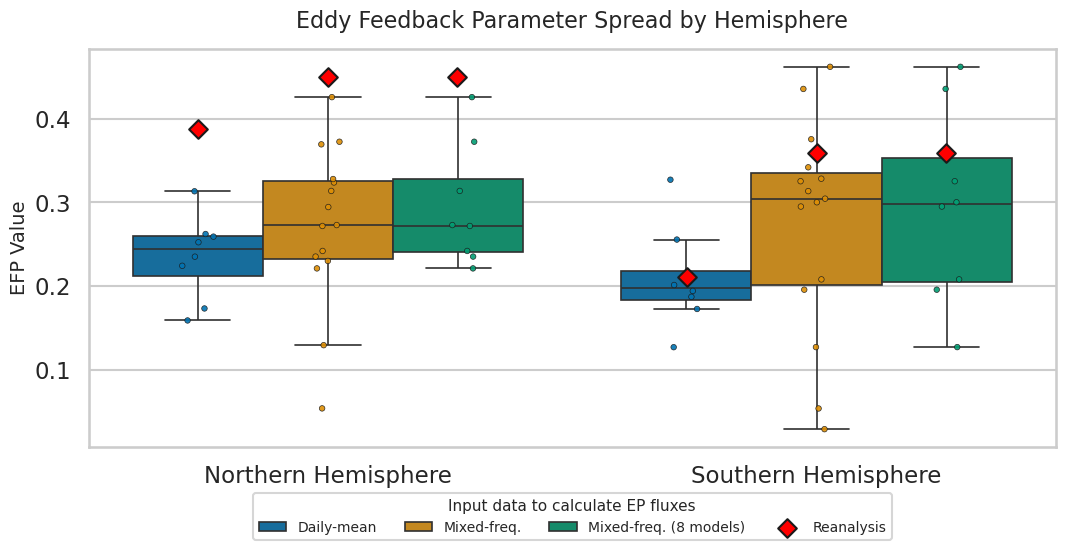

In [10]:
# Set style and context for clarity
sns.set_theme(style="whitegrid", context="talk", palette="colorblind")

plt.figure(figsize=(11,6))

# Boxplot
sns.boxplot(
    data=df_melt,
    x='hemisphere', y='efp', hue='dataset',
    linewidth=1.2, showfliers=False,
)

# Overlay stripplot to show individual model values
sns.stripplot(
    data=df_melt,
    x='hemisphere', y='efp', hue='dataset',
    dodge=True, alpha=0.9, size=4, jitter=True,
    marker="o", linewidth=0.5, edgecolor='k'
)

# --- Add custom points ---
points = {
    ("NH", "daily-mean"): 0.3872,
    ("NH", "sub-daily"): 0.4502,
    ("NH", "sub-daily8"): 0.4502,
    ("SH", "daily-mean"): 0.2116,
    ("SH", "sub-daily"): 0.3584,
    ("SH", "sub-daily8"): 0.3584,
}

ax = plt.gca()

positions = {
    ("NH", "daily-mean"): -0.265,
    ("NH", "sub-daily"):  0.0,
    ("NH", "sub-daily8"):  0.265,
    ("SH", "daily-mean"):  0.735,
    ("SH", "sub-daily"):  1.0,
    ("SH", "sub-daily8"):  1.265,
}

for (hemi, dataset), value in points.items():
    x = positions[(hemi, dataset)]
    ax.scatter(x, value, color='red', s=90, edgecolor='k', zorder=10, marker='D')

# --- Labels and legend cleanup ---
plt.xlabel("")
plt.ylabel("EFP Value", fontsize=14)
plt.title("Eddy Feedback Parameter Spread by Hemisphere", fontsize=16, pad=15)
plt.xticks(
    ticks=[0, 1],
    labels=["Northern Hemisphere", "Southern Hemisphere"]
)

# --- Custom legend ---
handles, labels = ax.get_legend_handles_labels()

# Remove duplicates (first 3 are from hue)
unique_handles = handles[0:3]
unique_labels = labels[0:3]

# Add proxy handle for the red diamonds
diamond_handle = plt.scatter([], [], color='red', edgecolor='k', marker='D', s=90, label='Reanalysis')
unique_handles.append(diamond_handle)
unique_labels.append('Reanalysis')

# Final legend
plt.legend(unique_handles, unique_labels,
           title="Input data to calculate EP fluxes",
           loc="lower center",
           bbox_to_anchor=(0.5, -0.25),
           ncol=4, fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()


---

# Reanalysis error bars

In [15]:
import pandas as pd
import numpy as np
import os

bootstrap_data = '/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/reanalysis/1979_2016'
files = os.listdir(bootstrap_data)

# Create empty lists to store data
efp_types = []
efp_means = []
efp_stds = []

for file in files:
    
    data = np.load(os.path.join(bootstrap_data, file))
    
    data_freq = file.split('_')[1]
    if data_freq == 'daily':
        freq = 'daily'
    else:
        freq = '6h'
    
    # skip non-'total' files
    which_k = file.split('_')[4]
    if which_k == 'djf-jra55':
        column = f'EFP_nh_{freq}'
        data_mean = np.mean(data, axis=0)
        data_std = np.std(data, axis=0)
    elif which_k == 'jas-jra55':
        column = f'EFP_sh_{freq}'
        data_mean = np.mean(data, axis=0)
        data_std = np.std(data, axis=0)
    else:
        continue
    
    # Append data to lists
    efp_types.append(column)
    efp_means.append(data_mean)
    efp_stds.append(data_std)
    
    print(file)
    print(column,':', data_mean, f'[{data_mean - data_std:.3f}, {data_mean + data_std:.3f}]')

# Create pandas DataFrame
bootstrap_df = pd.DataFrame({
    'efp_type': efp_types,
    'efp_mean': efp_means,
    'efp_std': efp_stds
})

bootstrap_df

reanalysis_6h_div1_QG_djf-jra55_efp.npy
EFP_nh_6h : 0.4094005 [0.357, 0.462]
reanalysis_daily_div1_QG_jas-jra55_efp.npy
EFP_sh_daily : 0.2198312 [0.187, 0.252]
reanalysis_daily_div1_QG_djf-jra55_efp.npy
EFP_nh_daily : 0.35690639999999996 [0.306, 0.408]
reanalysis_6h_div1_QG_jas-jra55_efp.npy
EFP_sh_6h : 0.33680400000000005 [0.301, 0.373]


,efp_type,efp_mean,efp_std
0,EFP_nh_6h,0.409401,0.052243
1,EFP_sh_daily,0.219831,0.032533
2,EFP_nh_daily,0.356906,0.050626
3,EFP_sh_6h,0.336804,0.035887


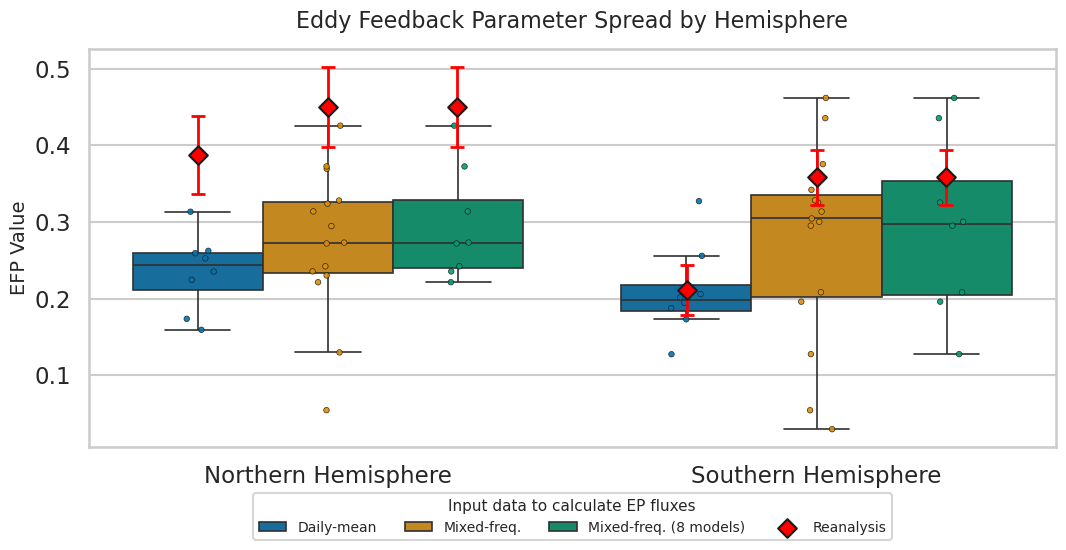

In [16]:
# Set style and context for clarity
sns.set_theme(style="whitegrid", context="talk", palette="colorblind")

plt.figure(figsize=(11,6))

# Boxplot
sns.boxplot(
    data=df_melt,
    x='hemisphere', y='efp', hue='dataset',
    linewidth=1.2, showfliers=False,
)

# Overlay stripplot to show individual model values
sns.stripplot(
    data=df_melt,
    x='hemisphere', y='efp', hue='dataset',
    dodge=True, alpha=0.9, size=4, jitter=True,
    marker="o", linewidth=0.5, edgecolor='k'
)

# --- Add custom points with error bars ---
points = {
    ("NH", "daily-mean"): 0.3872,
    ("NH", "sub-daily"): 0.4502,
    ("NH", "sub-daily8"): 0.4502,
    ("SH", "daily-mean"): 0.2116,
    ("SH", "sub-daily"): 0.3584,
    ("SH", "sub-daily8"): 0.3584,
}

# Define standard deviations for each point based on your bootstrap_df
std_errors = {
    ("NH", "daily-mean"): 0.050626,  # EFP_nh_daily
    ("NH", "sub-daily"): 0.052243,   # EFP_nh_6h
    ("NH", "sub-daily8"): 0.052243,  # EFP_nh_6h
    ("SH", "daily-mean"): 0.032533,  # EFP_sh_daily
    ("SH", "sub-daily"): 0.035887,   # EFP_sh_6h
    ("SH", "sub-daily8"): 0.035887,  # EFP_sh_6h
}

ax = plt.gca()

positions = {
    ("NH", "daily-mean"): -0.265,
    ("NH", "sub-daily"):  0.0,
    ("NH", "sub-daily8"):  0.265,
    ("SH", "daily-mean"):  0.735,
    ("SH", "sub-daily"):  1.0,
    ("SH", "sub-daily8"):  1.265,
}

for (hemi, dataset), value in points.items():
    x = positions[(hemi, dataset)]
    yerr = std_errors[(hemi, dataset)]
    
    # Plot the point with error bars
    ax.errorbar(x, value, yerr=yerr, 
                color='red', linewidth=2, capsize=5, capthick=2, zorder=10)
    
    # Overlay the diamond marker
    ax.scatter(x, value, color='red', s=90, edgecolor='k', zorder=11, marker='D')

# --- Labels and legend cleanup ---
plt.xlabel("")
plt.ylabel("EFP Value", fontsize=14)
plt.title("Eddy Feedback Parameter Spread by Hemisphere", fontsize=16, pad=15)
plt.xticks(
    ticks=[0, 1],
    labels=["Northern Hemisphere", "Southern Hemisphere"]
)

# --- Custom legend ---
handles, labels = ax.get_legend_handles_labels()

# Remove duplicates (first 3 are from hue)
unique_handles = handles[0:3]
unique_labels = labels[0:3]

# Add proxy handle for the red diamonds with error bars
diamond_handle = plt.scatter([], [], color='red', edgecolor='k', marker='D', s=90, label='Reanalysis')
unique_handles.append(diamond_handle)
unique_labels.append('Reanalysis')

# Final legend
plt.legend(unique_handles, unique_labels,
           title="Input data to calculate EP fluxes",
           loc="lower center",
           bbox_to_anchor=(0.5, -0.25),
           ncol=4, fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()